In [15]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Administrator\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [16]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Administrator\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [17]:
from ultralytics import YOLO
import cv2
import pytesseract
import matplotlib.pyplot as plt
import re

In [51]:
model = YOLO("bestPlate.pt")


0: 640x608 2 Templates, 388.4ms
Speed: 7.6ms preprocess, 388.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


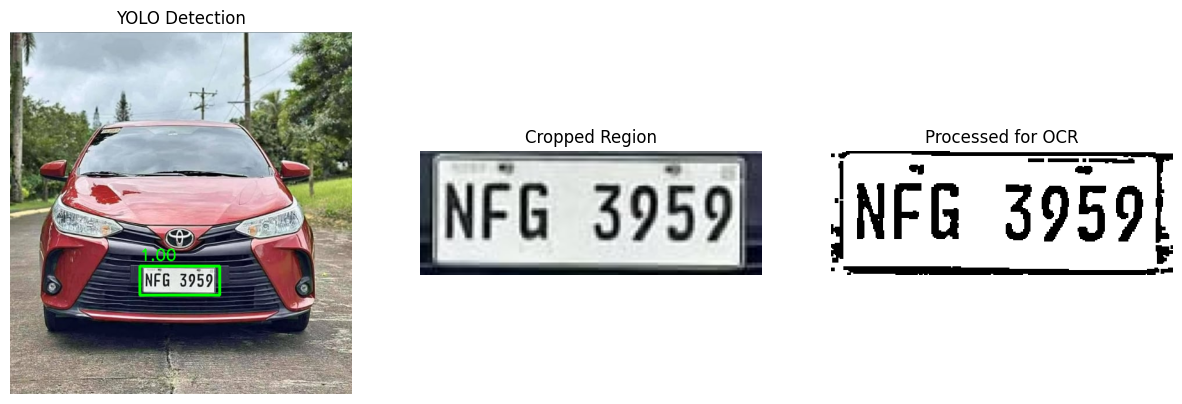

Extracted Text: INFG3959
Detection Confidence: 1.00


In [55]:
import cv2
import pytesseract
import re
import numpy as np
import matplotlib.pyplot as plt


if __name__ == "__main__":
    result_text, confidence = detect_and_ocr("PlateTest.jpg")
    print(f"Extracted Text: {result_text}")
    print(f"Detection Confidence: {confidence:.2f}")



def detect_and_ocr(image_path):
    img = cv2.imread(image_path)
    results = model(img)

    best_crop, best_conf = None, 0
    x1 = y1 = x2 = y2 = 0  

    for r in results:
        for box in r.boxes:
            conf = float(box.conf[0])
            if conf > best_conf:
                best_conf = conf
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                best_crop = img[y1:y2, x1:x2]

    plate_text = ""
    if best_crop is not None:
        gray = cv2.cvtColor(best_crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        kernel = np.array([[0, -1, 0],
                           [-1, 5,-1],
                           [0, -1, 0]])
        sharp = cv2.filter2D(gray, -1, kernel)

        thresh = cv2.adaptiveThreshold(
            sharp, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            35, 15
        )

        kernel_morph = np.ones((3,3), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_morph)

        raw = pytesseract.image_to_string(
            thresh,
            config="--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        ).strip().upper()

        cleaned = re.sub(r"[^A-Z0-9]", "", raw)

        match = re.match(r"^([A-Z]{3})(\d{4})", cleaned)
        if match:
            plate_text = match.group(1) + match.group(2)
        else:
            plate_text = cleaned

        if len(plate_text) == 7 and plate_text[-1] == "6":
            plate_text = plate_text[:-1] + "0"

        
        fig, axs = plt.subplots(1, 3, figsize=(15, 6))

        img_box = img.copy()
        cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 255, 0), 3)
        label = f"{best_conf:.2f}"
        cv2.putText(img_box, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        axs[0].imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
        axs[0].set_title("YOLO Detection")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(best_crop, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Cropped Region")
        axs[1].axis("off")

        axs[2].imshow(thresh, cmap="gray")
        axs[2].set_title("Processed for OCR")
        axs[2].axis("off")

        plt.show()

    return plate_text, best_conf
